In [1]:
import os
import math

import pytest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import norm # Norm cdf from scipy
from statistics import NormalDist # Norm cdf from std library
from math import erf, sqrt # Norm cdf using error function

from starkware.starknet.testing.starknet import Starknet

In [2]:
# Functions for generating std norm cdf (plus "norm" from scipy)
norm_py_std_lib = NormalDist().cdf
norm_py_math = lambda x: (1.0 + erf(x / sqrt(2.0))) / 2.0

In [3]:
# The path to the contract source code
TESTABLE_CONTRACT_FILE = os.path.join("tests", "testable_option_pricing.cairo")
CONTR_FILE_2 = os.path.join(".", "black_scholes_contract.cairo")
CONTR_FILE_3 = os.path.join(".", "bs.cairo")

Math64x61_FRACT_PART = 2 ** 61

In [5]:
# Start the network and deploy contracts 
net = await Starknet.empty()

contract = await net.deploy(source = '/home/chepe/Desktop/carmine/carmine-protocol/tests/testable_option_pricing.cairo', cairo_path = ['../../'])
contract_2 = await net.deploy(source = CONTR_FILE_2, cairo_path = ['../../'])
contract_3 = await net.deploy(source = CONTR_FILE_3, cairo_path = ['../../'])

In [3]:
# Generating numbers from python and cairo
# One of the contracts starts throwing errors after around x=7 so the comparison between the three
# is only done up to that point(doesnt really matter ), zero is excluded as well 


# Comparison for our contract only for the whole -30->30 range can be found at the bottom

std = {}
std['xs'] = [i / 10 for i in range(-300, 300)]
std['xs'].remove(0)

std['py'] = {}

std['py']['sci_py'] = [norm.cdf(i) for i in std['xs']]
std['py']['std_lib_py'] = [norm_py_std_lib(i) for i in std['xs']]
std['py']['math_py'] = [norm_py_math(i) for i in std['xs']]

std['cairo'] = {}
std['cairo']['our'] = []
std['cairo']['second'] = []
std['cairo']['third'] = []

a = len(std['xs'])

for ix, x in enumerate(std['xs']):
    try:
        if ix % 5 == 0:
            print(f'{ix} out of {a} done.')
        num_our = int(x * Math64x61_FRACT_PART)
        num_2_3 = int(x * 10**27)

        res_our = await contract.testable_std_normal_cdf(x = num_our).call()
        res_2 = await contract_2.std_normal_cdf(x = num_2_3).call()
        res_3 = await contract_3.std_normal_cdf(x = num_2_3).call()

        std['cairo']['our'].append(res_our.result[0] /  Math64x61_FRACT_PART)
        std['cairo']['second'].append(res_2.result[0] / 10**27)
        std['cairo']['third'].append(res_3.result[0] / 10**27)
    except:
        !spd-say "ERROR ERROR ERROR"
        raise SystemExit
!spd-say "DONE DONE DONE"

In [13]:
# It can take quite a while for the data to load, so they are provided in a pickle file
# std_norm.pickle contains data for comparing the three contracts all at once, data for our contract only 
# can be found below 

# import pickle

# with open('std_norm.pickle', 'wb') as f:
#     pickle.dump(std, f)

# with open('std_norm.pickle', 'rb') as f:
#     std = pickle.load(f)

In [14]:
py = std['py']
cairo = std['cairo']

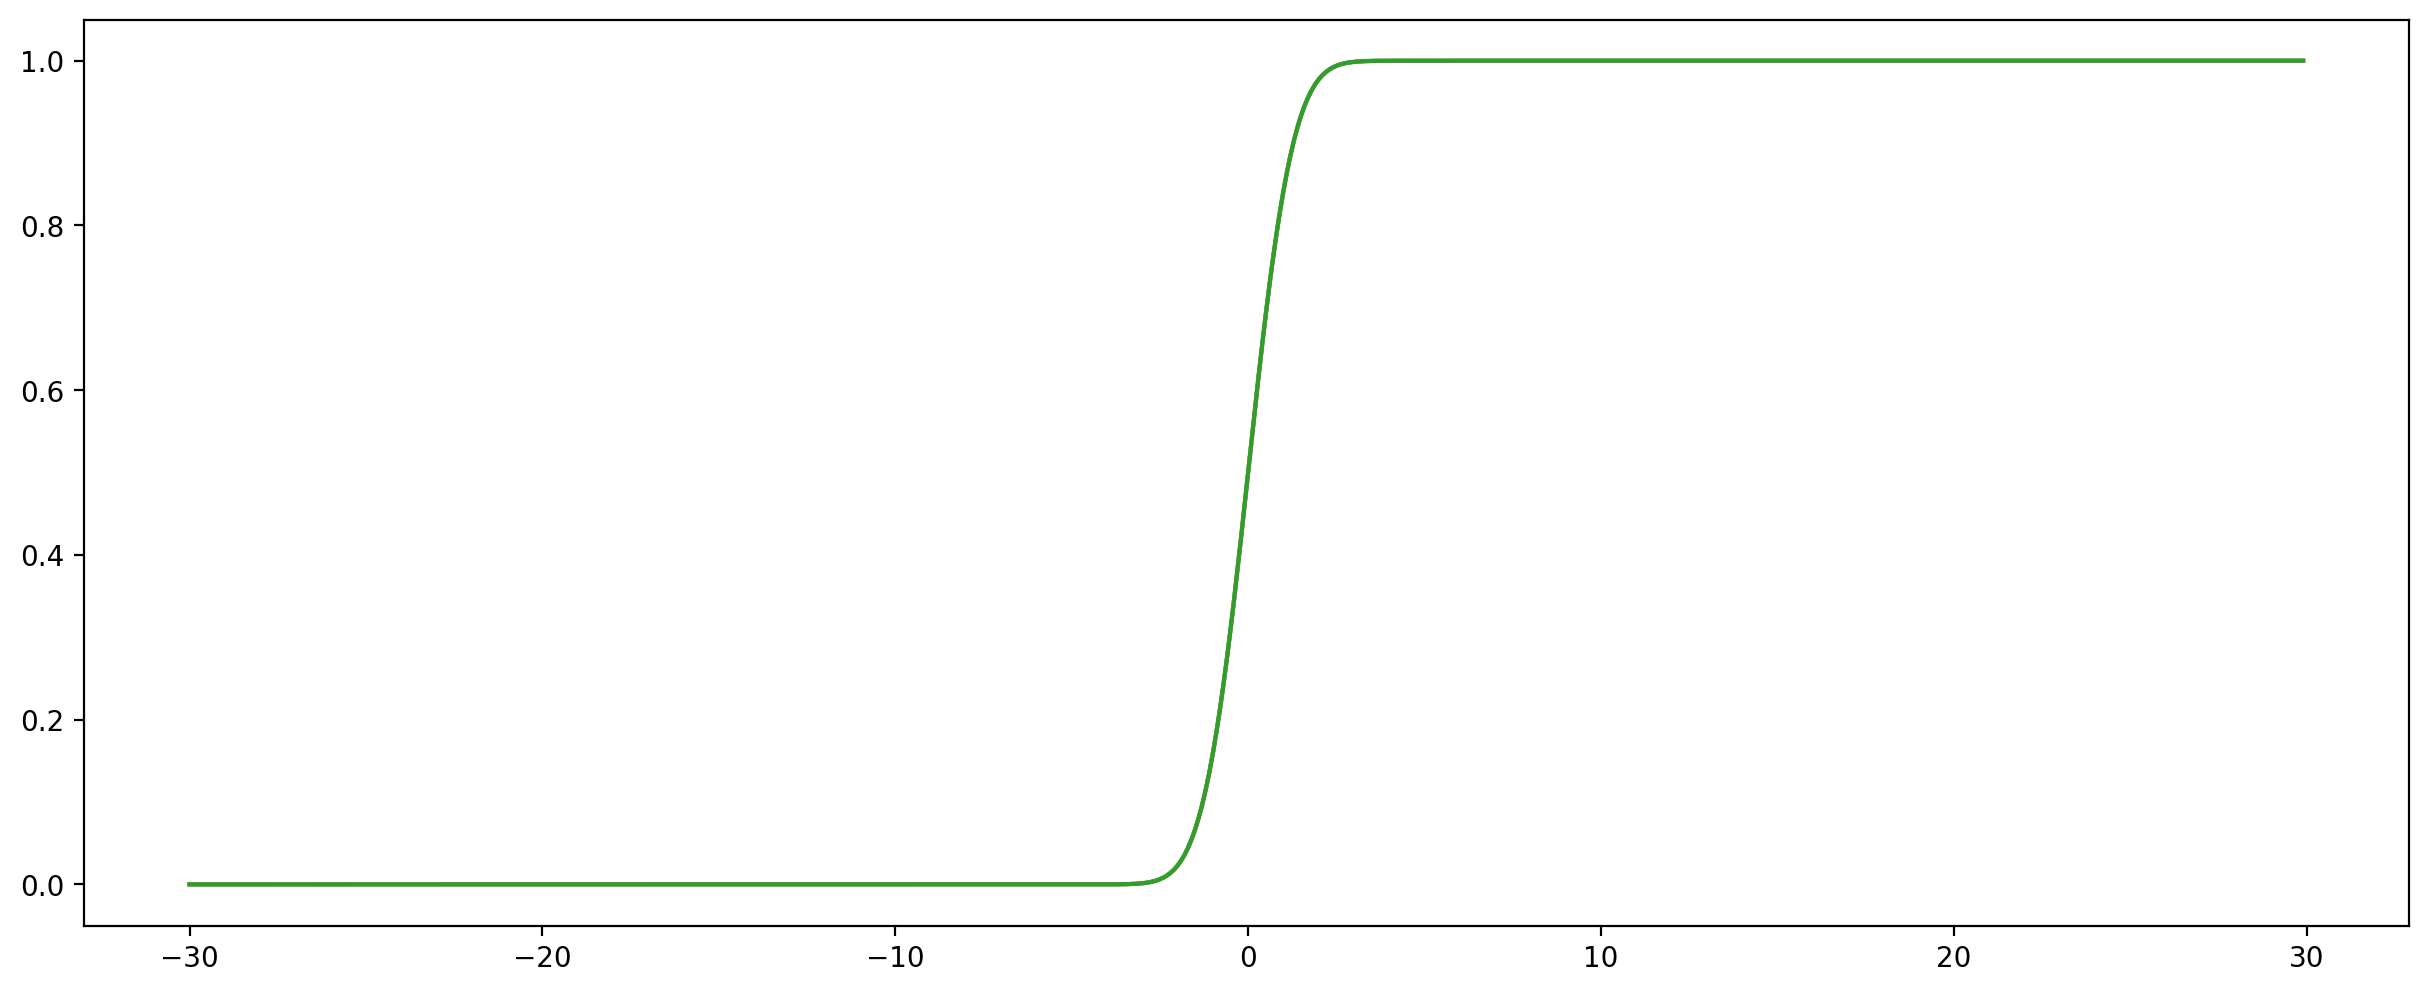

In [38]:
plt.figure(dpi=200, figsize=(15, 6))
plt.plot(std['xs'], py['sci_py'])
plt.plot(std['xs'], py['std_lib_py'])
plt.plot(std['xs'], py['math_py'])

In [39]:
# Check that the numbers provided by different libs are the same(up to 10th decimal)
for sp, slp, mp in zip(*py.values()):
    sp, slp, mp = np.round([sp, slp, mp], 10)
    if sp==slp==mp:
        continue
    print(sp, slp, mp)

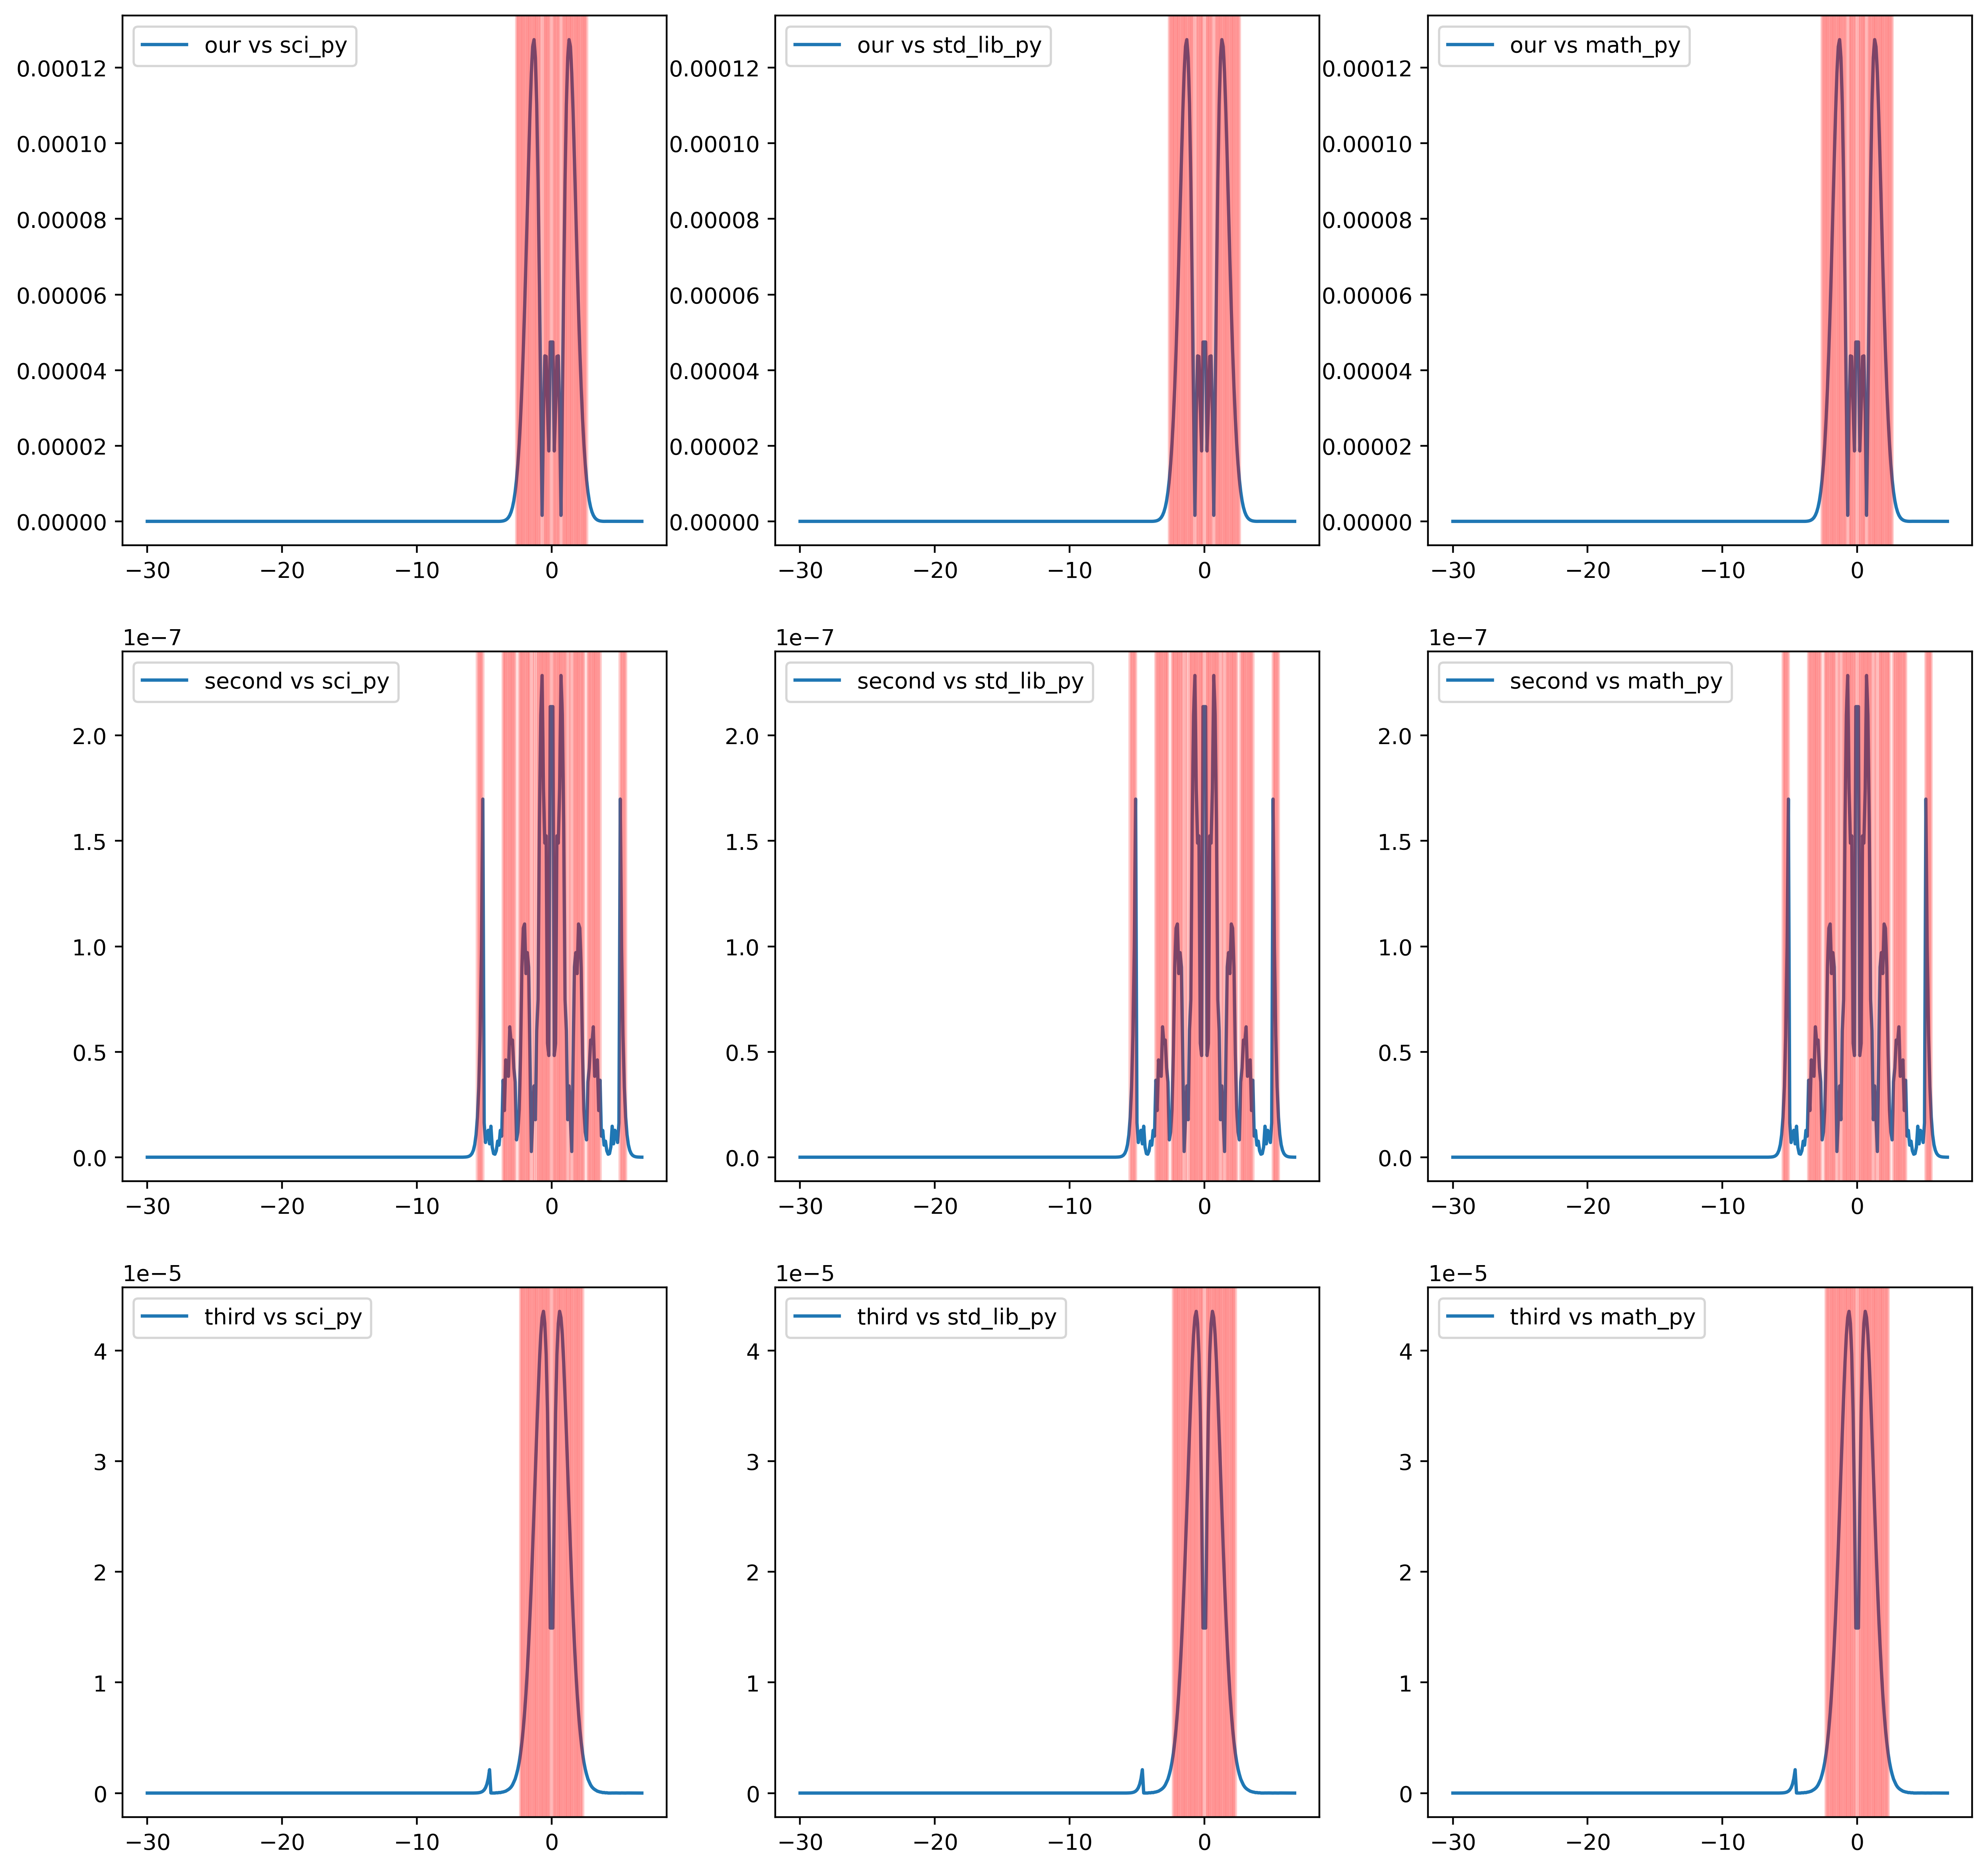

In [15]:
# Plots of absolute erorrs 

# Red regions mark errors above the mean

fig, ax = plt.subplots(ncols = 3, nrows = 3)
fig.set_dpi(400)
fig.set_size_inches(15, 15)

for cix, (ckey, cvals) in enumerate(cairo.items()):
    for pix, (pkey, pvals) in enumerate(py.items()):
        tmp = [abs(c-p) for c, p in zip(cvals, pvals)]
        ax[cix][pix].plot(std['xs'][:len(cvals)], tmp, label = f'{ckey} vs {pkey}')
        ax[cix][pix].legend()
        
        tmp_above_mean = [(i, x) for i, x in zip(tmp, std['xs']) if i > np.mean(tmp)]
        for sth in tmp_above_mean:
            ax[cix][pix].axvline(x = sth[1], color = 'red', alpha = 0.2)

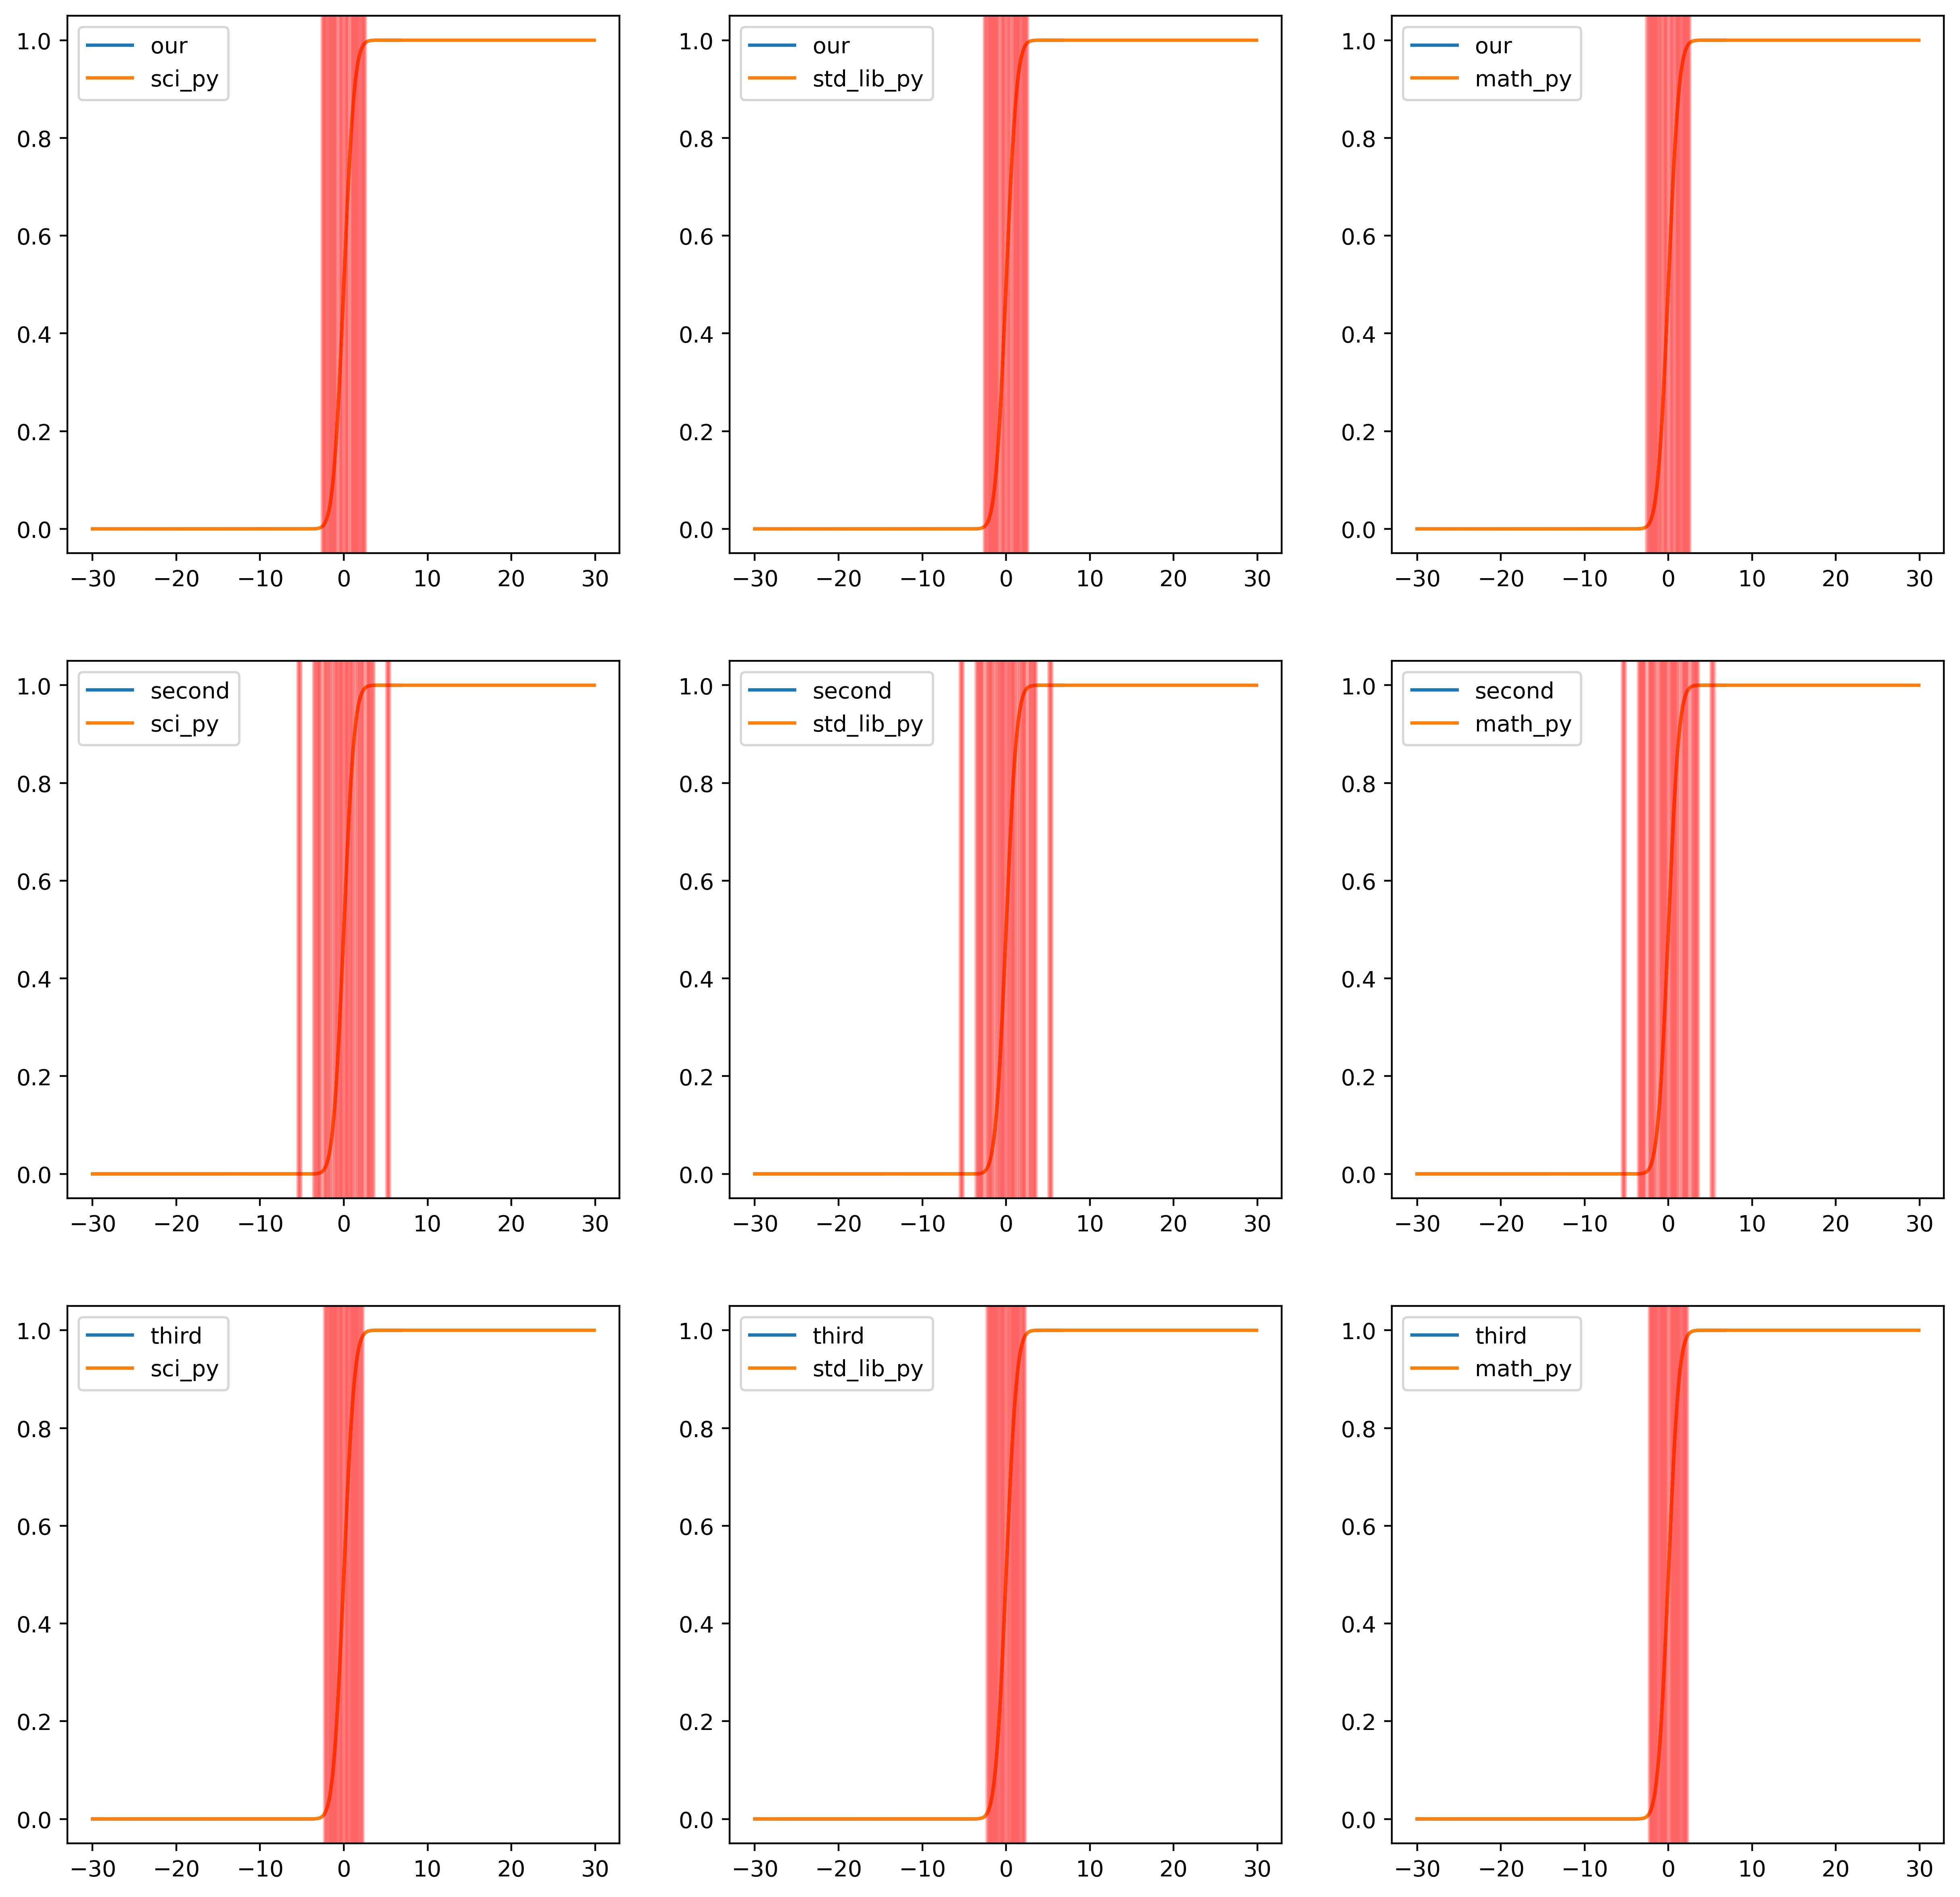

In [41]:
# Plots of CDF 

fig, ax = plt.subplots(ncols = 3, nrows = 3)
fig.set_dpi(400)
fig.set_size_inches(15, 15)

for cix, (ckey, cvals) in enumerate(cairo.items()):
    for pix, (pkey, pvals) in enumerate(py.items()):
        ax[cix][pix].plot(std['xs'][:len(cvals)], cvals, label = ckey)
        ax[cix][pix].plot(std['xs'][:len(pvals)], pvals, label = pkey)
        ax[cix][pix].legend()
        
        tmp = [abs(c-p) for c, p in zip(cvals, pvals)]
        tmp_above_mean = [(i, x) for i, x in zip(tmp, std['xs']) if i > np.mean(tmp)]
        for sth in tmp_above_mean:
            ax[cix][pix].axvline(x = sth[1], color = 'red', alpha = 0.2)

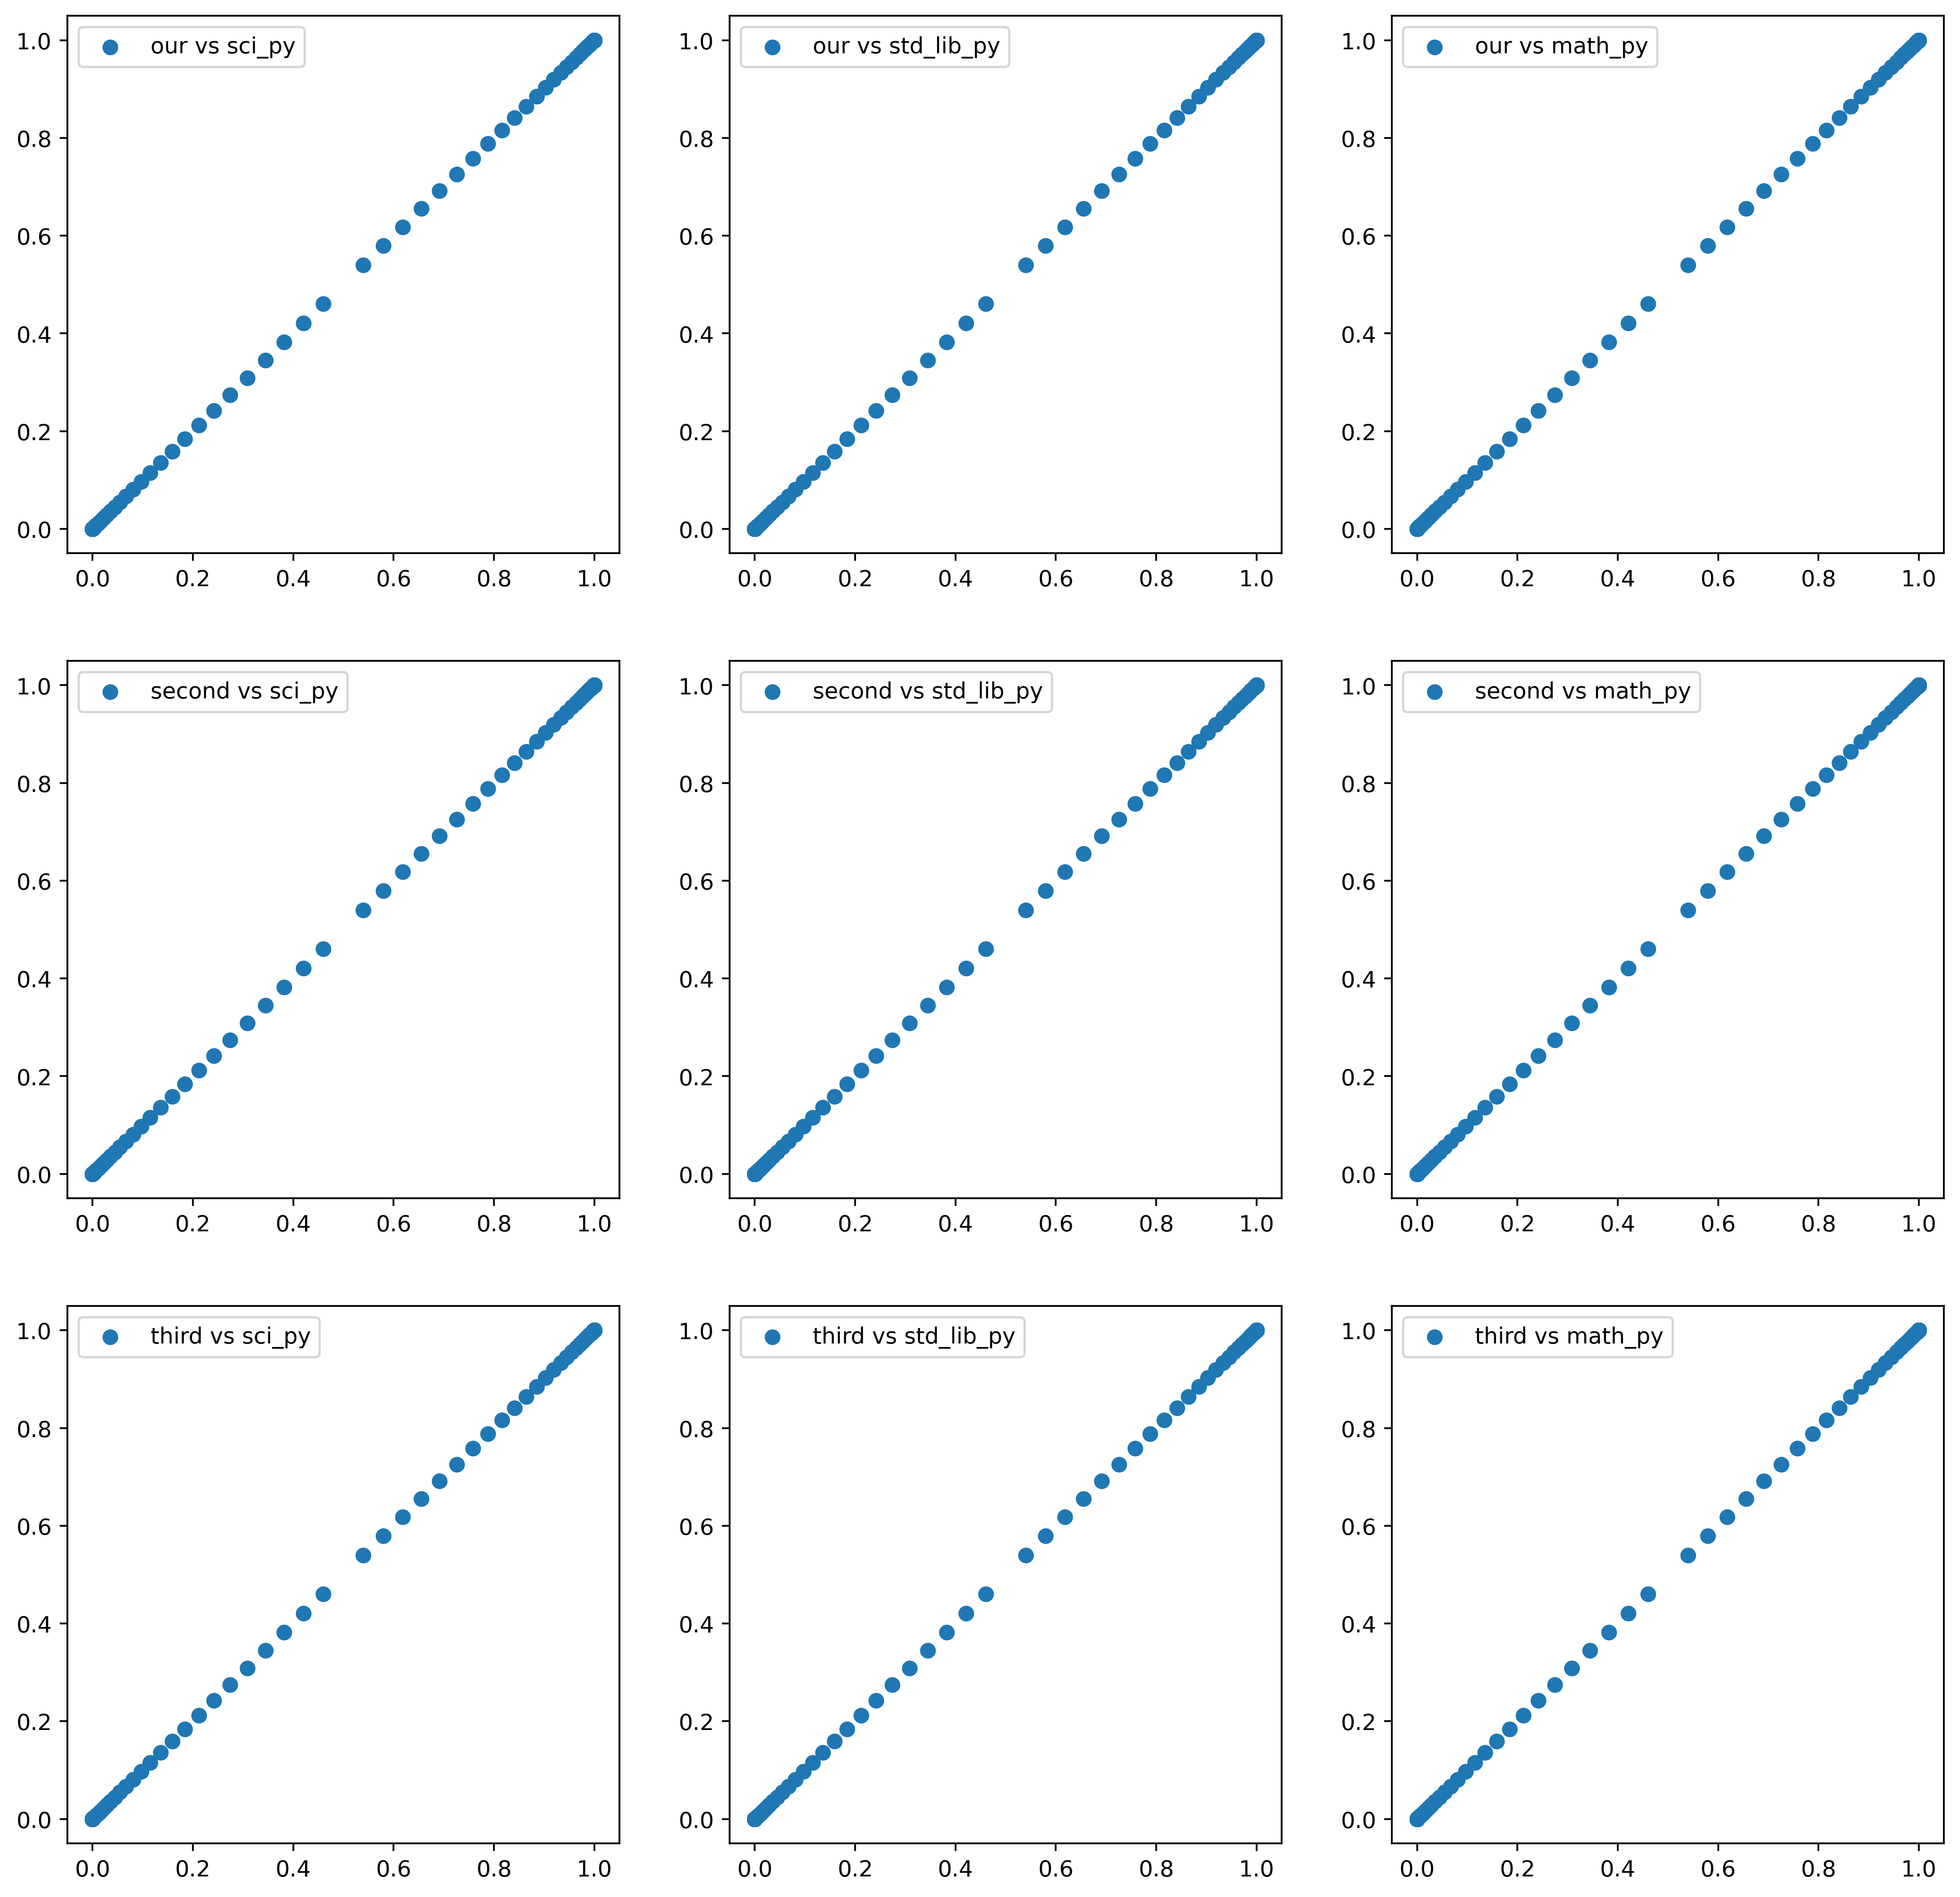

In [43]:
# Scatter plots 

fig, ax = plt.subplots(ncols = 3, nrows = 3)
fig.set_dpi(400)
fig.set_size_inches(15, 15)

for cix, (ckey, cvals) in enumerate(cairo.items()):
    for pix, (pkey, pvals) in enumerate(py.items()):
        ax[cix][pix].scatter(pvals[:len(cvals)], cvals, label = f"{ckey} vs {pkey}")
        ax[cix][pix].legend()
        
#         tmp = [abs(c-p) for c, p in zip(cvals, pvals)]
#         tmp_above_mean = [(i, x) for i, x in zip(tmp, std['xs']) if i > np.mean(tmp)]
#         for sth in tmp_above_mean:
#             ax[cix][pix].axvline(x = sth[1], color = 'red', alpha = 0.2)

In [49]:
# Basic stats of absolute diffs

for cix, (ckey, cvals) in enumerate(cairo.items()):
    for pix, (pkey, pvals) in enumerate(py.items()):
        tmp = [abs(c-p) for c, p in zip(cvals, pvals)]
        
        print(f'{ckey} vs {pkey} mean: {np.mean(tmp)}')
        print(f'{ckey} vs {pkey} max: {np.max(tmp)}')
        print(f'{ckey} vs {pkey} min: {np.min(tmp)}')
        print('-----------------------------------------------------')

our vs sci_py mean: 8.662538976289277e-06
our vs sci_py max: 0.0001274255038576505
our vs sci_py min: 4.906713927147908e-198
-----------------------------------------------------
our vs std_lib_py mean: 8.662538976290578e-06
our vs std_lib_py max: 0.0001274255038576505
our vs std_lib_py min: 0.0
-----------------------------------------------------
our vs math_py mean: 8.662538976290578e-06
our vs math_py max: 0.0001274255038576505
our vs math_py min: 0.0
-----------------------------------------------------
second vs sci_py mean: 1.780550906178684e-08
second vs sci_py max: 2.2843959304741368e-07
second vs sci_py min: 4.906713927147908e-198
-----------------------------------------------------
second vs std_lib_py mean: 1.7805509062977495e-08
second vs std_lib_py max: 2.2843959304741368e-07
second vs std_lib_py min: 0.0
-----------------------------------------------------
second vs math_py mean: 1.7805509062977495e-08
second vs math_py max: 2.2843959304741368e-07
second vs math_py min

In [88]:
# Comparison of our contract only 

std_our = {}
std_our['xs'] = [i / 10 for i in range(-300, 300)]

std_our['py'] = {}

std_our['py']['sci_py'] = [norm.cdf(i) for i in std_our['xs']]
std_our['py']['std_lib_py'] = [norm_py_std_lib(i) for i in std_our['xs']]
std_our['py']['math_py'] = [norm_py_math(i) for i in std_our['xs']]

std_our['cairo'] = []

a = len(std_our['xs'])

for ix, x in enumerate(std_our['xs']):
    try:
        if ix % 5 == 0:
            print(f'{ix} out of {a} done.')
        num_our = int(x * Math64x61_FRACT_PART)

        res = await contract.testable_std_normal_cdf(x = num_our).call()

        std_our['cairo'].append(res.result[0] /  Math64x61_FRACT_PART)

    except:
        !spd-say "ERROR ERROR ERROR"
        raise SystemExit
!spd-say "DONE DONE DONE"

In [67]:
# Data saved in std_our.pickle

# with open('std_our.pickle', 'wb') as f:
#     pickle.dump(std_our, f)

# with open('std_our.pickle', 'rb') as f:
#     std_our = pickle.load(f)

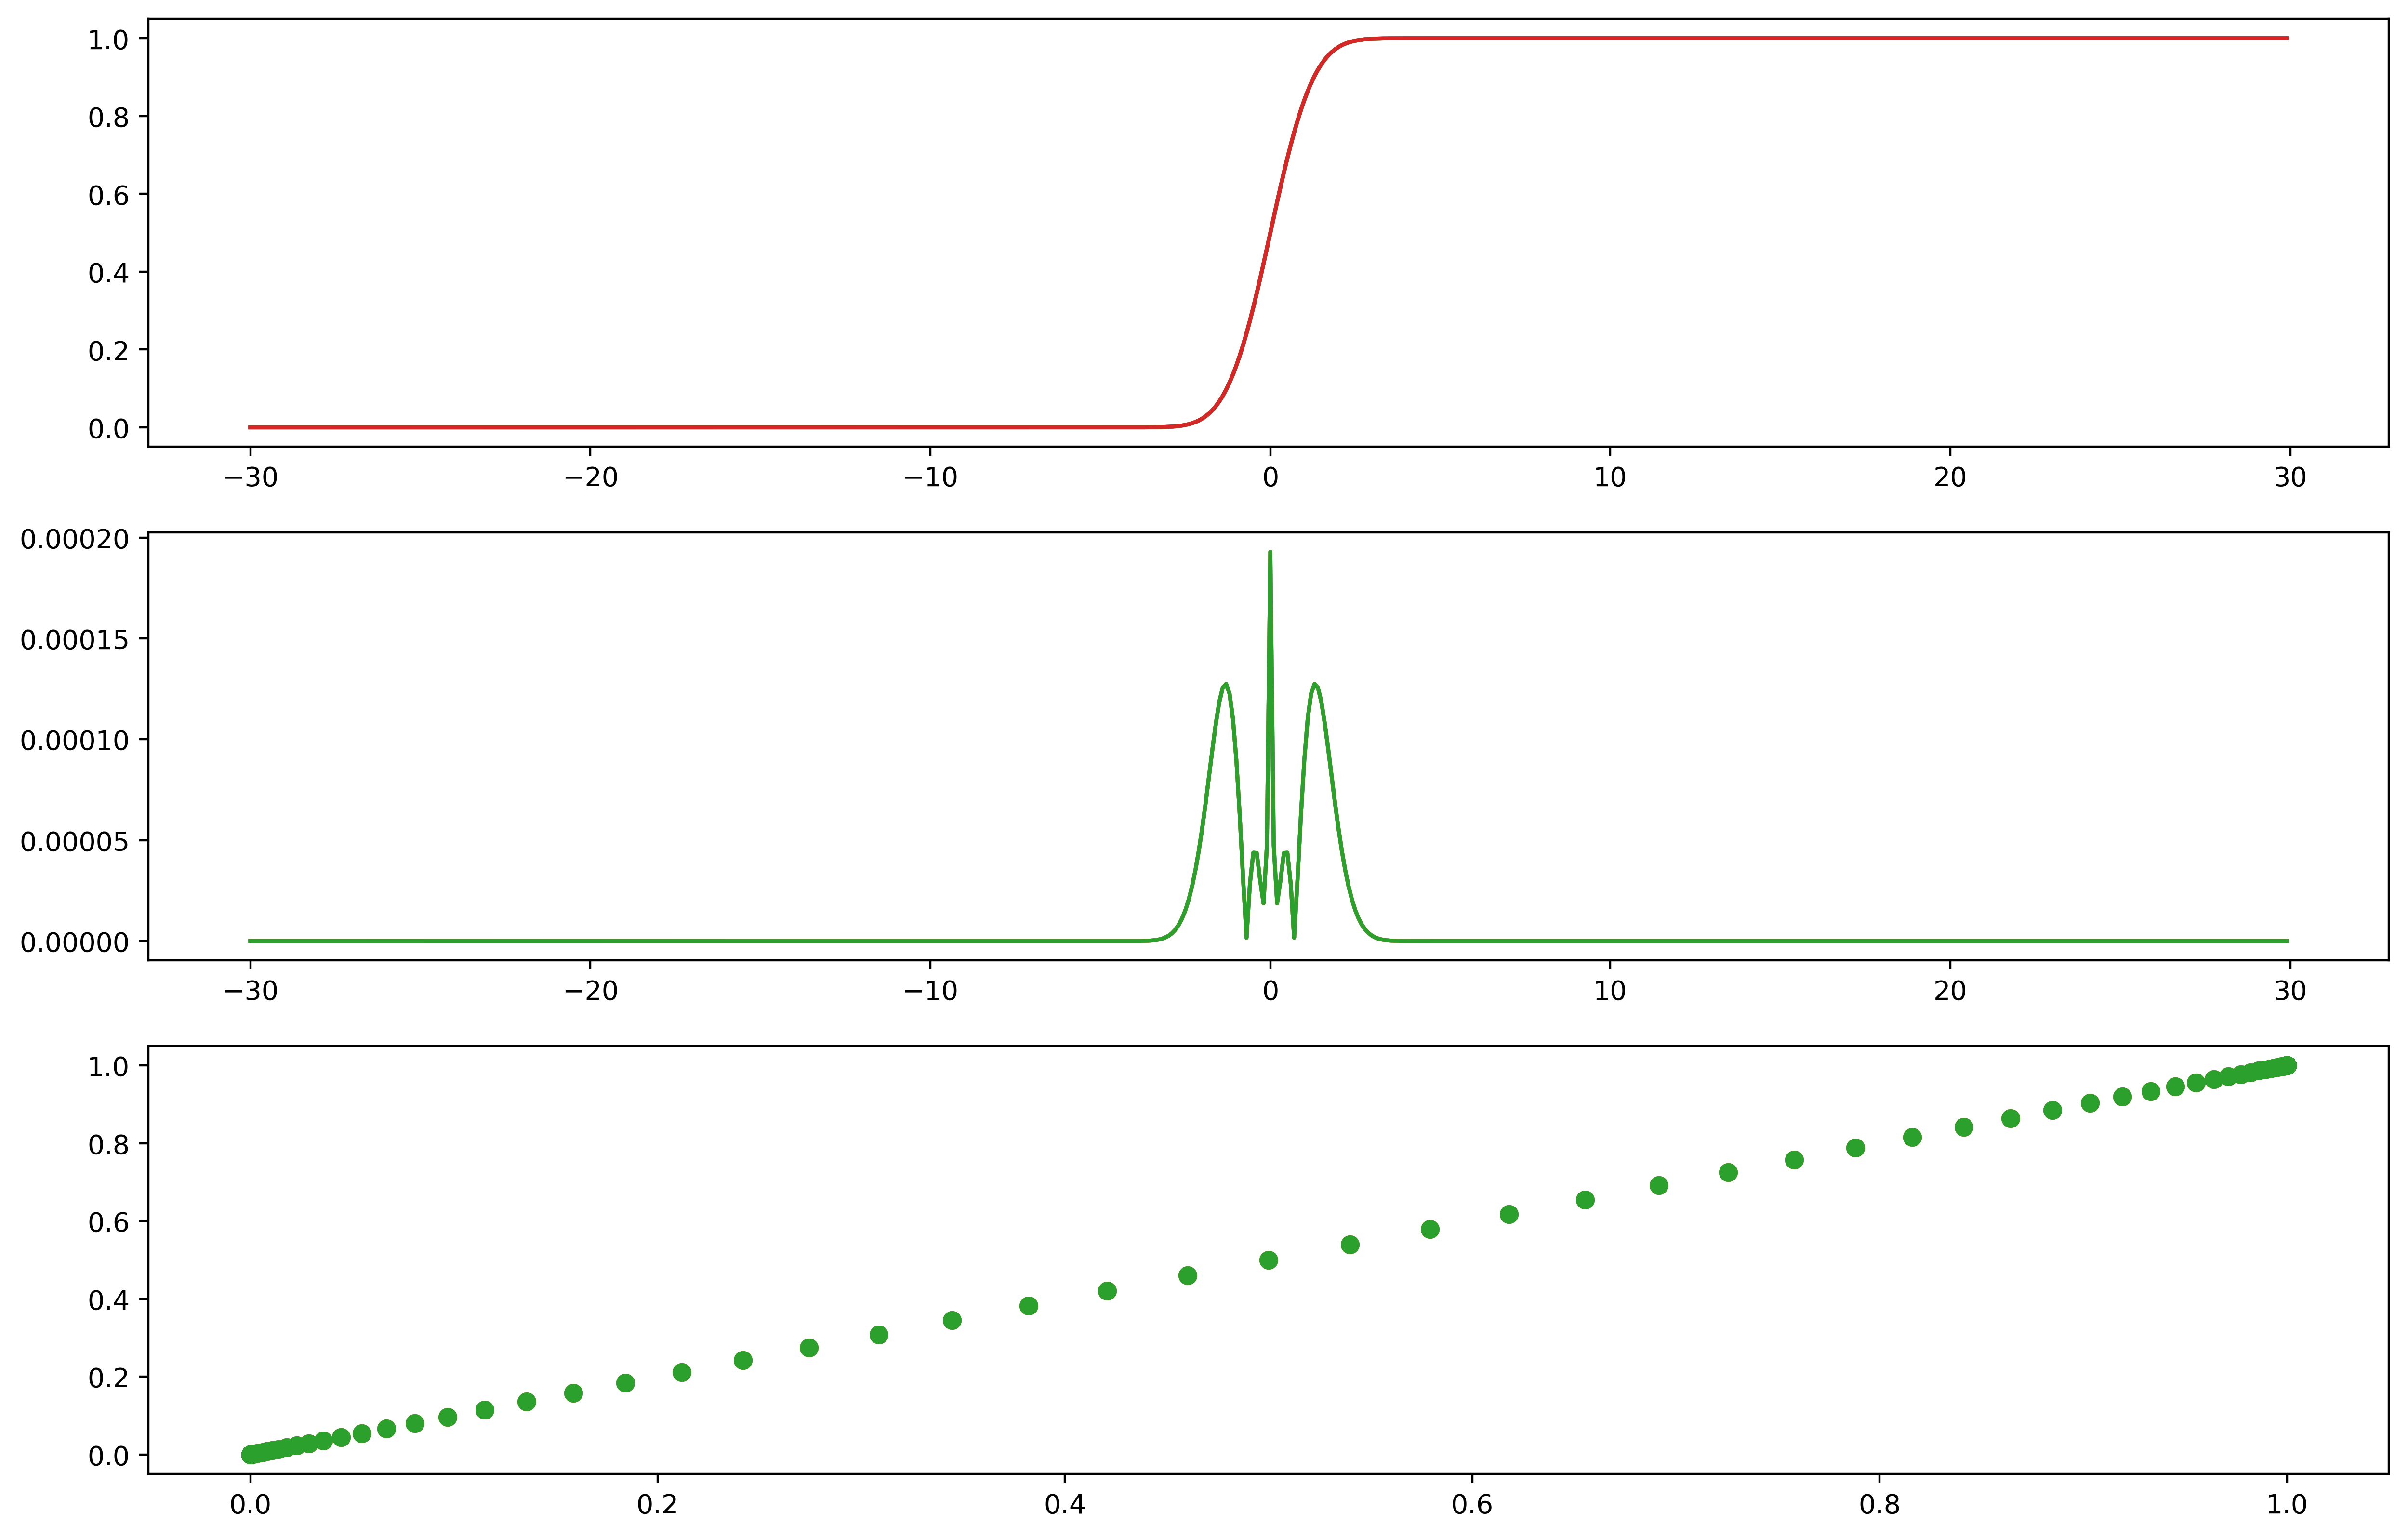

In [82]:
fig, (overlay, diffs, scatt) = plt.subplots(ncols = 1, nrows = 3)
fig.set_dpi(400)
fig.set_size_inches(15, 10)

diff_sci = [abs(p-c) for p, c in zip(std_our['py']['sci_py'], std_our['cairo'])]
diff_std_lib = [abs(p-c) for p, c in zip(std_our['py']['std_lib_py'], std_our['cairo'])]
diff_math = [abs(p-c) for p, c in zip(std_our['py']['math_py'], std_our['cairo'])]

# Overlay of CDFs
overlay.plot(std_our['xs'], std_our['cairo'])
overlay.plot(std_our['xs'], std_our['py']['sci_py'])
overlay.plot(std_our['xs'], std_our['py']['std_lib_py'])
overlay.plot(std_our['xs'], std_our['py']['math_py'])

# Abs differences
diffs.plot(std_our['xs'], diff_sci)
diffs.plot(std_our['xs'], diff_std_lib)
diffs.plot(std_our['xs'], diff_math)

# Scatter plot 
scatt.scatter(std_our['py']['sci_py'], std_our['cairo'])
scatt.scatter(std_our['py']['std_lib_py'], std_our['cairo'])
scatt.scatter(std_our['py']['math_py'], std_our['cairo'])

Since the python functions return basically the same numbers(at least with 10 decimals precision), the plots look exactly the same when comparing them with our cairo approximation. 

In [87]:
print(f'Mean abs. diff. compared to SciPy: {np.mean(diff_sci)}')
print(f'Mean abs. diff. compared to Std. Lib.: {np.mean(diff_std_lib)}')
print(f'Mean abs. diff. compared to Math: {np.mean(diff_math)}')
print('-----------------------------------------------------------')
print(f'Max abs. diff. compared to SciPy: {np.max(diff_sci)}')
print(f'Max abs. diff. compared to Std. Lib.: {np.max(diff_std_lib)}')
print(f'Max abs. diff. compared to Math: {np.max(diff_math)}')
print('-----------------------------------------------------------')
print(f'Min abs. diff. compared to SciPy: {np.min(diff_sci)}')
print(f'Min abs. diff. compared to Std. Lib.: {np.min(diff_std_lib)}')
print(f'Min abs. diff. compared to Math: {np.min(diff_math)}')

Mean abs. diff. compared to SciPy: 5.620178804645401e-06
Mean abs. diff. compared to Std. Lib.: 5.620178804645827e-06
Mean abs. diff. compared to Math: 5.620178804645827e-06
-----------------------------------------------------------
Max abs. diff. compared to SciPy: 0.00019295547841580163
Max abs. diff. compared to Std. Lib.: 0.00019295547841580163
Max abs. diff. compared to Math: 0.00019295547841580163
-----------------------------------------------------------
Min abs. diff. compared to SciPy: 0.0
Min abs. diff. compared to Std. Lib.: 0.0
Min abs. diff. compared to Math: 0.0


### With the maximum absolute difference being lower than 2/10000 it's fair to say that to approximation is sufficient enough, especially for demo purposes. The errors are highest in bound circa (-3, 3) with tail values being more precise.  


### Other contracts might have smaller errors, but return errors with some numbers. 